In [1]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import torch
from torch import nn
import numpy as np
from icecream import ic
from tqdm import tqdm
from get_data import *
from dataloader import *
from test_function import test
from NN_classes import *

# Use the GPU if available
torch.set_default_dtype(torch.float64)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
#device="cpu"
print(device)

cpu


In [ ]:
# Import the data generated via matlab/simulink:

# see get_data.py for more info

#save_data_test_revised.csv

data_tensor, PSW_max = get_data(path = r"data\save_data_test_5xlonger.csv", timesteps_from_data=0,
                                 skip_steps_start = 0, skip_steps_end = 0, drop_half_timesteps = True, normalise_s_w="minmax", rescale_p=False, num_inits=0)

# View an example of a simulation run
visualise(data_tensor, num_inits=2000)

In [ ]:
input_data_new = input_data[0:3,0:15,:].clone()
input_data_new[0:1,:,0:1] = 1
input_data_new[0:1,:,1:2] = 2
input_data_new[0:1,:,2:] = 3
input_data_new[1:2,:,0:1] = 4
input_data_new[1:2,:,1:2] = 5
input_data_new[1:2,:,2:] = 6
input_data_new[2:,:,0:1] = 7
input_data_new[2:,:,1:2] = 8
input_data_new[2:,:,2:] = 9

model(input_data_new)


input_data size torch.Size([50, 2750, 3])
torch.Size([1, 534, 2])
torch.Size([1, 550, 3]) torch.Size([550, 3])


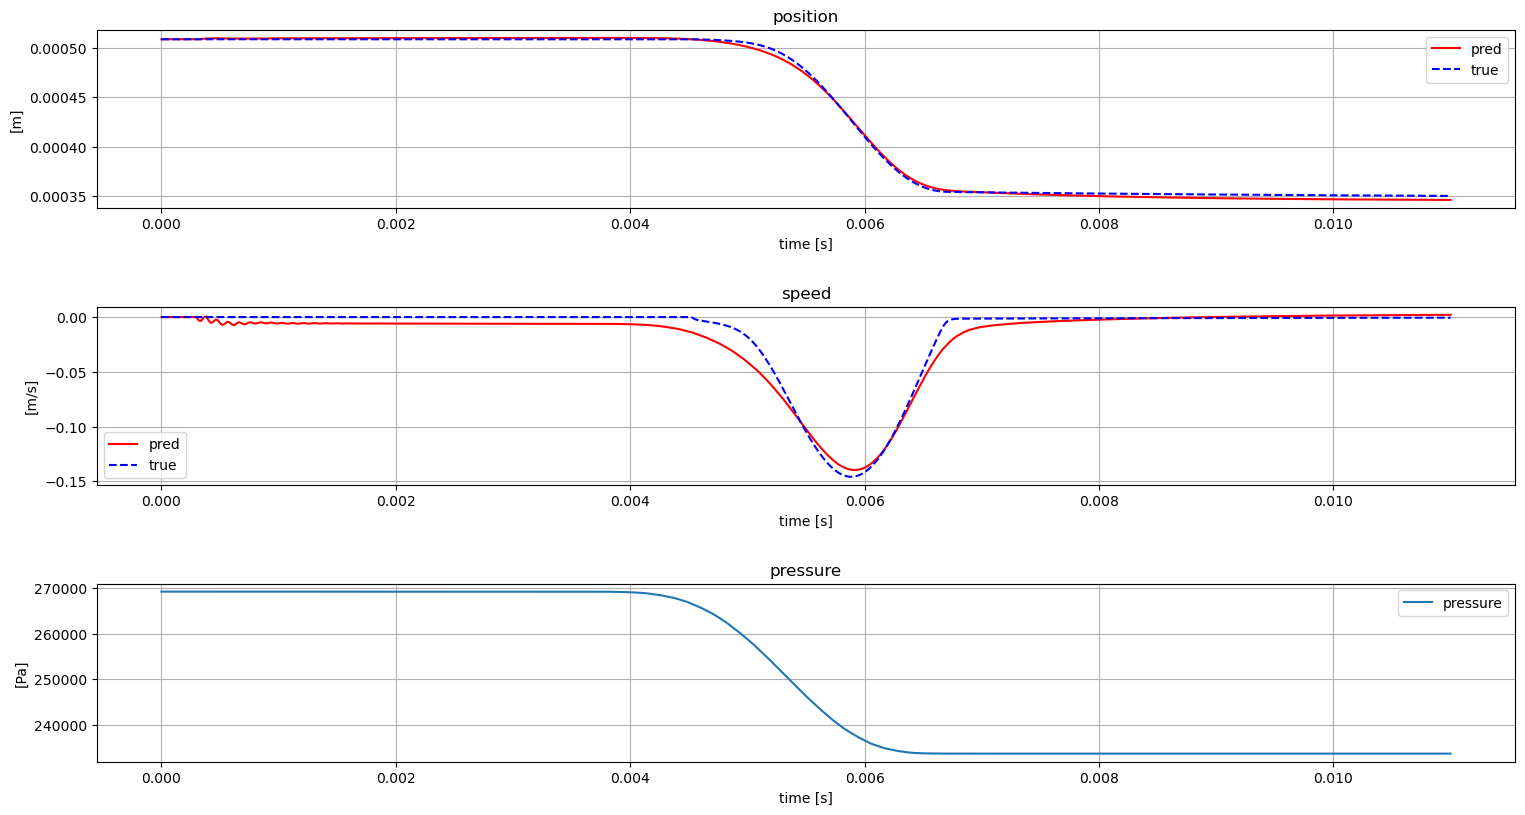

Error first half:  8.466620886632233e-06
Error second half:  1.4510674897764119e-05
total loss full traj:  1.1669743143468044e-05
1.1669743143468044e-05


In [2]:
# Save the model
# path = f"Ventil_trained_NNs\lstm_ws0.pth"
# #
# torch.save(model.state_dict(), path)

# Load the model and test it on the test data
#path = "Ventil_trained_NNs\OR_LSTM0.pth"
path = "working_networks/OR_lstm_16_8_3_best_V2.pth"

params =                 {
                           "experiment_number" : 2,
                           "window_size" : 16,
                           "h_size" : 8,
                           "l_num" : 3,
                           "epochs" : 3000,
                           "learning_rate" : 0.0008,
                           "part_of_data" : 0, 
                           "weight_decay" : 0,
                           "percentage_of_data" : 0.8,
                           "future_decay"  : 0.5,
                           "batch_size" : 20,
                           "future" : 10,
                           "cut_off_timesteps" : 0,
                           "drop_half_timesteps": True
                        }



input_data1, PSW_max = get_data(path = "data/save_data_test_5xlonger.csv", 
                        timesteps_from_data=0, 
                        skip_steps_start = 0,
                        skip_steps_end = 0, 
                        drop_half_timesteps = params["drop_half_timesteps"],
                        normalise_s_w="minmax",
                        rescale_p=False,
                        num_inits=params["part_of_data"])

input_data2, PSW_max = get_data(path = "data/save_data_test_5xlonger_dyndyn.csv", 
                        timesteps_from_data=0, 
                        skip_steps_start = 0,
                        skip_steps_end = 0, 
                        drop_half_timesteps = params["drop_half_timesteps"],
                        normalise_s_w="minmax",
                        rescale_p=False,
                        num_inits=params["part_of_data"])

input_data3, PSW_max = get_data(path = "data/Testruns_from_trajectory_generator_t2_t6_revised.csv", 
                        timesteps_from_data=0, 
                        skip_steps_start = 0,
                        skip_steps_end = 0, 
                        drop_half_timesteps = params["drop_half_timesteps"],
                        normalise_s_w="minmax",
                        rescale_p=False,
                        num_inits=params["part_of_data"])
                        

#input_data = torch.cat((input_data1, input_data2, input_data3))
input_data=input_data2
np.random.seed(1234)
print("input_data size", input_data.size())
num_of_inits_train = int(len(input_data)*params["percentage_of_data"])
train_inits = np.random.choice(np.arange(len(input_data)),num_of_inits_train,replace=False)
test_inits = np.array([x for x in range(len(input_data)) if x not in train_inits])
np.random.shuffle(train_inits)
np.random.shuffle(test_inits)
test_data = input_data[test_inits,:,:]
np.random.seed()

# Initialize the LSTM model

model = LSTMmodel(input_size=3, hidden_size=params["h_size"], out_size=2, layers=params["l_num"], window_size=params["window_size"])

model.load_state_dict(torch.load(path, map_location=torch.device(device)))

train_data = input_data[train_inits,:,:]
#%matplotlib qt 
#%matplotlib inline 

#test_loss, test_loss_deriv, total_loss, physloss
test_loss, test_loss_deriv, total_loss = test(input_data2, model, model_type = "or_lstm", window_size=params["window_size"],
                                                         display_plots=True, num_of_inits = 1, set_rand_seed=False, physics_rescaling = PSW_max, additional_data=None)
print(total_loss)
#test_loss, test_loss_deriv, total_loss = test(train_data, model, steps=input_data.size(dim=1), ws=params["window_size"], plot_opt=True , n = 1,  test_inits=len(test_data), rand=False, PSW_max=0)

#[350000.0, 0.0006, 1.7, 0.0, 0.0, -1.7]
#  TCN : 0.0044
#  LSTM : 0.002437618255471458

In [ ]:
# Anzahl parameter im Modell

import torch
from torchviz import make_dot
from IPython.display import Image

print(input_data2[0:1,0:17,:].size())

print(list(model.parameters()))

#calc 
erg=0
for a in list(model.parameters()):
    x = 1 
    for y in list(a.size()):
        x = x*y
    erg += x

print("anzahl der variablen" , erg)
